In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
img = cv2.imread("./lena.jpg")
print("original img size：{}".format(img.shape))

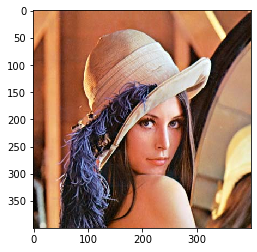

In [3]:
plt.imshow(img[:,:,::-1])

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("gray img size：{}".format(gray.shape))

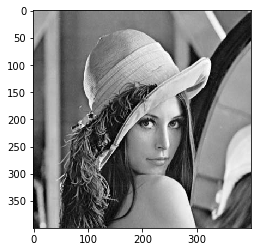

In [5]:
plt.imshow(gray,cmap='gray')

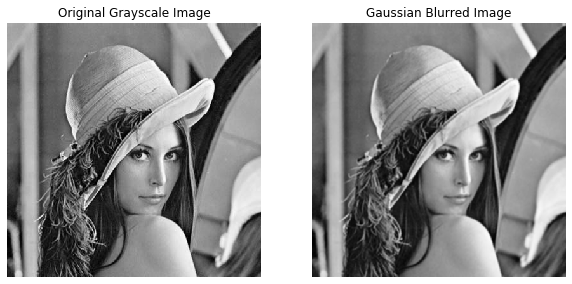

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_gaussian_blur(image_path, kernel_size, sigma):
    
    # 
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"err: {image_path}")

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    
    blurred_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), sigma)

    return gray_image, blurred_image

image_path = 'lena.jpg'  
kernel_size = 3
sigma = 1.2

gray_image, blurred_image = apply_gaussian_blur(image_path, kernel_size, sigma)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Grayscale Image")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Gaussian Blurred Image")
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')

plt.show()


In [7]:
from pynq import DefaultIP

class SobelDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)

    bindto = ['xilinx.com:hls:gaussian_blur:1.0']

    def gaussian(self, imgi, imgo, rows, cols):      
        
        self.write(0x10, rows)
        self.write(0x18, cols)
        self.register_map.CTRL.AP_START = 1
        
        dma.sendchannel.transfer(imgi)
        dma.recvchannel.transfer(imgo)
        dma.sendchannel.wait() # wait for send channel
        dma.recvchannel.wait() # wait for recv channel
        
        res = imgo.reshape(rows, cols)
        return res

In [8]:
import pynq
from pynq import Overlay, allocate
#overlay = Overlay("./gaussian_blur_acc.bit")
overlay = Overlay("./gaussian_blur.bit")
dma = overlay.axi_dma_0
gaussian_blur = overlay.gaussian_blur_0

In [12]:
import time
# allocate memory
rows, cols= gray.shape
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

# input
gray_new = np.uint8(gray)
np.copyto(input_buffer, gray_new.flatten())

rails = pynq.get_rails()
if 'VSYS' in rails.keys():
    print("Recording Ultra96 v1 power...")
    rail_name = 'VSYS'
elif 'INT' in rails.keys():
    print("Recording Ultra96 v2 power...")
    rail_name = 'INT'
else:
    raise RuntimeError("Cannot determine Ultra96 board version.")
recorder = pynq.DataRecorder(rails[rail_name].power)
recorder.reset()
time.sleep(2)
with recorder.record(0.01):
    recorder.mark()
    start_time = time.time()
    for _ in range(10000):
        res = gaussian_blur.gaussian(input_buffer, output_buffer, rows, cols)
    end_time = time.time()
    recorder.mark()
power_data = recorder.frame
working_power = np.mean(power_data)

print("Predict Power consumption: %.2f J" % (working_power[1] * (end_time - start_time)))

Recording Ultra96 v2 power...
Predict Power consumption: 0.22 J


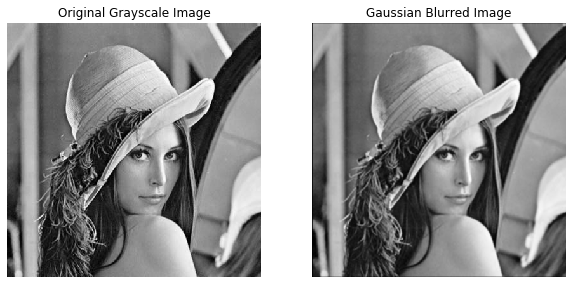

In [13]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Grayscale Image")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Gaussian Blurred Image")
plt.imshow(res, cmap='gray')
plt.axis('off')

plt.show()